Mathematical Programs with Equilibrium Constraint (MPEC) problems arise in a
large number of applications in engineering and economic systems.

An MPEC is an optimization problem that includes equilibrium constraints in the
form of complementarity conditions.

MPEC models can be easily expressed with
Pyomo modeling components for complementarity conditions. Further, Pyomo’s
object-oriented design naturally supports the ability to automate the reformulation
of MPEC models into other forms (MIP or NLP), and solve them with regular solvers. 

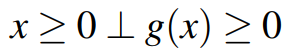

which expresses the complementarity restriction that at least one of these must hold
with equality.

g(x) >= 0, x >= 0, x.g(x) == 0

# Mixed complementary condition

When the variable x is bounded such that x ∈ [l,u], then a mixed
complementarity condition can be expressed as:

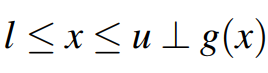

When the variable x is bounded such that x ∈ [l,u], then a mixed
complementarity condition can be expressed as:

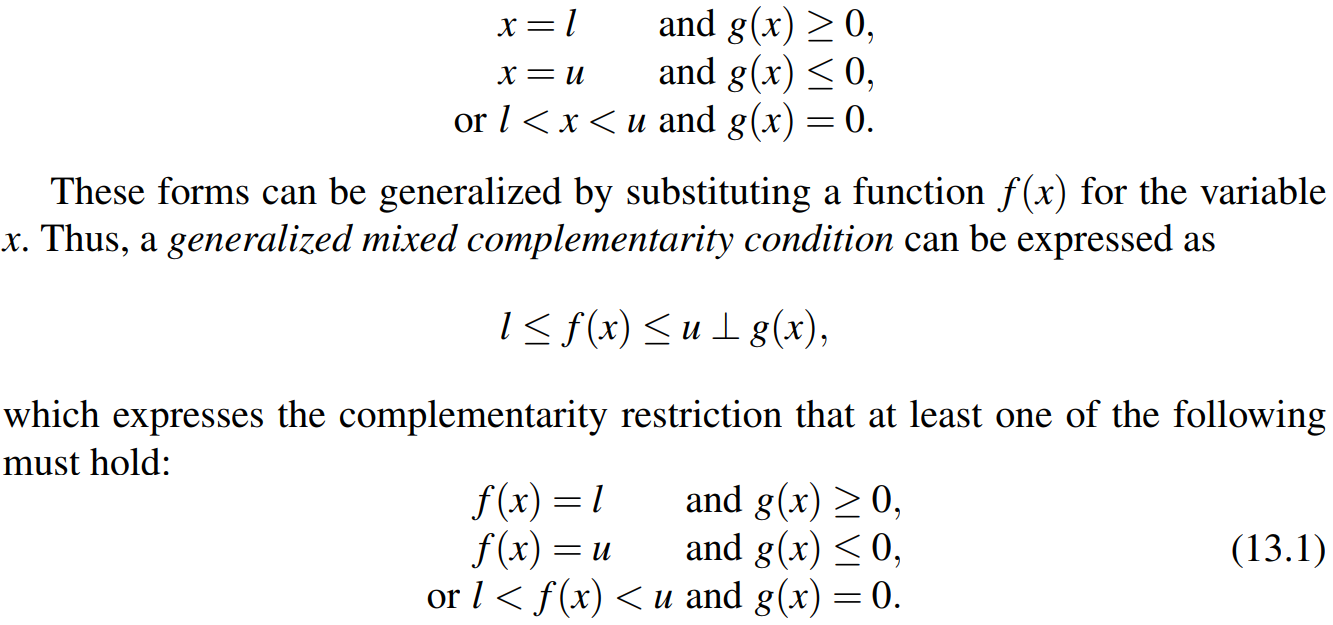

## more info

https://www.gams.com/mccarlGuide/mixed_complementarity_problem_(mcp).htm

https://www.artelys.com/docs/knitro/2_userGuide/complementarity.html#:~:text=Intuitively%2C%20a%20complementarity%20constraint%20is,may%20be%200%20as%20well).

In [1]:
import pyomo.environ as pyo
from pyomo.mpec import Complementarity, complements

# example 1

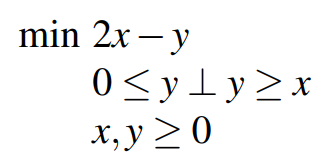

In [13]:
model = pyo.ConcreteModel()

model.x = pyo.Var( within=pyo.NonNegativeReals )
model.y = pyo.Var( within=pyo.NonNegativeReals )

model.f1 = pyo.Objective( expr=2*model.x - model.y )

In [14]:
model.compl = Complementarity( expr = complements(0 <= model.y, model.y >= model.x) )

# example 2

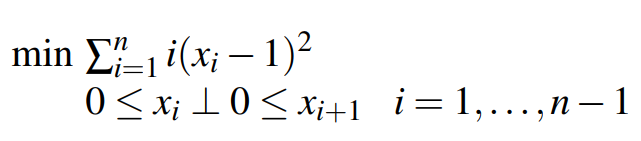

In [20]:
n = 5

mdl = pyo.ConcreteModel()

mdl.x = pyo.Var( range(1,n+1) )

mdl.f = pyo.Objective( expr = sum(i*(mdl.x[i]-1)**2 for i in range(1,n+1)) )

In [21]:
def compl_(mdl, i):
    return complements(mdl.x[i] >= 0, mdl.x[i+1] >= 0)
mdl.compl = Complementarity( range(1,n), rule=compl_ )

# alternative ways of formulation

#def compl_(model, i):
#    if i == n:
#        return Complementarity.Skip
#    return complements(model.x[i] >= 0, model.x[i+1] >= 0)
#model.compl = Complementarity( range(1,n+1), rule=compl_ )

#model.compl = ComplementarityList( rule=(complements(model.x[i] >= 0, model.x[i+1] >= 0) for i in range(1,n)) )

# MPEC transformation

In [22]:
xfrm = pyo.TransformationFactory("mpec.simple_nonlinear") # linear: mpec.simple_disjunction, nonlinear: mpec.simple_nonlinear
transformed = xfrm.create_using(mdl)

The **mpec.simple_nonlinear** transformation provides a generic way for transforming an MPEC into a nonlinear program. while **mpec.simple_disjunction** transformation provides a generic way for transforming an MPEC into a linear program

In [23]:
solver=pyo.SolverFactory("mpec_nlp")   # linear: mpec_minlp (glpk),  nonlinear: mpec_nlp (ipopt)
solver.solve(transformed, tee=True)

    'pyomo.core.base.param.ScalarParam'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.param.ScalarParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        8
Number of nonzeros in inequality constraint Jacobian

{'Problem': [{'Name': 'unknown', 'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 12, 'Number of variables': 9, 'Number of binary variables': None, 'Number of integer variables': None, 'Number of continuous variables': None, 'Sense': 'unknown'}], 'Solver': [{'Name': None, 'Status': 'ok', 'Wallclock time': 0.06877899169921875, 'Termination condition': 'unknown'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### first problem

In [19]:
print(pyo.value(transformed.x))
print(pyo.value(transformed.y))

0.0
0.0


### second problem

In [24]:
for i in range(n):
    print(pyo.value(transformed.x[i+1]))

0.9999999908864446
9.13270487756537e-09
0.9999999905669883
9.63990150497523e-09
0.9999999961636492
